In [1]:
import deepSI_jax
from deepSI_jax import get_nu_ny_and_auto_norm
from deepSI_jax.utils import NRMS_error
import numpy as np

# Data generation
We utilize a similar system for data generation as previously, but now we add (a significant amount of) process noise. Furthermore, now the test data will consist of 2 signals, to show how `deepSI-jax` can handle multiple measurement signals as a test datas set.

In [2]:
# Generate data
np.random.seed(0)
U = np.random.randn(10_000) # Input sequence
x = [0, 0] # Initial state
ylist = [] # Output sequence
K = np.array([0.75, -0.65])
for uk in U:
    ek = np.random.normal(loc=0, scale=0.05)
    ylist.append(x[0] + ek)  # Compute output
    x = x[0] / (1.2 + x[1]**2) + x[1] * 0.4 + K[0] * x[0] * ek, \
        x[1] / (1.2 + x[0]**2) + x[0] * 0.4 + uk + K[1] * x[1] * ek  # Advance state
Y = np.array(ylist)

U2 = np.random.randn(500) # Input sequence nr. 2
x = [0, 0] # Initial state nr. 2
ylist = [] # Output sequence nr. 2
for uk in U2:
    ek = np.random.normal(loc=0, scale=0.05)
    ylist.append(x[0] + ek)  # Compute output
    x = x[0] / (1.2 + x[1]**2) + x[1] * 0.4 + K[0] * x[0] * ek, \
        x[1] / (1.2 + x[0]**2) + x[0] * 0.4 + uk + K[1] * x[1] * ek  # Advance state
Y2 = np.array(ylist)

# Split dataset
U_train = U[:9000]
Y_train = Y[:9000]
U_test_1 = U[9000:]
Y_test_1 = Y[9000:]
U_test_2 = U2
Y_test_2 = Y2
U_test = [U_test_1, U_test_2]
Y_test = [Y_test_1, Y_test_2]

# The innovation noise structure
The applied ANN-SS model with the innovation noise filter can be expressed as
$$\hat{x}_{k+1} = f_\theta(\hat{x}_k, u_k, \hat{e}_k),$$
$$\hat{y}_{k} = h_\theta(\hat{x}_k, u_k),$$
where $f$ and $h$ are again implemented as feedforward neural networks with the vector $\theta$ combining their parameters. Furthermore, the model error $\hat{e}_k$ is computed as
$$\hat{e}_k = y_k - \hat{y}_k.$$

It can be noticed that the model with this option corresponds to a one-step-ahead prediction setup. If one would want to utilize the final model for simulation (i.e., multi-step-ahead prediction), the approximation $\hat{e}_k\approx 0$ can be used.

Initialization of the SUBNET approach with the innovation noise filter can be achieved similarly as the original SUBNET method, only changing the `SUBNET` class to `SUBNET_innovation`, as shown.

In [3]:
nu, ny, norm = get_nu_ny_and_auto_norm(Y_train, U_train)
nx = 3
n_lag = 20

f_dict = dict(nodes_per_layer=32)
h_dict = dict(feedthrough=False)
encoder_dict = dict(nodes_per_layer=16)

model = deepSI_jax.SUBNET_innovation(nx=nx, ny=ny, nu=nu, norm=norm, f_args=f_dict, h_args=h_dict, use_encoder=True, encoder_lag=n_lag, encoder_args=encoder_dict, seed=2)

Then, the training process is the same as for the simple SUBNET structure.

In [4]:
# set loss function and optimization parameters
model.set_loss_fun(T=200, l2_reg=1e-4)   # no overlap (for simplicity)
model.optimization(adam_epochs=100, lbfgs_epochs=500, iprint=-1)  # can be trained longer for even better results

# Train model on data
model.fit(Y_train, U_train)

t0 = model.t_solve
print(f"Elapsed time: {t0} s")

L-BFGS-B done in 463 iterations.
Elapsed time: 15.621151208877563 s


# Model evaluations
For models that incorporate a process noise structure (like the innovation filter), two options are available in `deepSI-jax` for testing. One is the standard one-step-ahead prediction, where the current measured (true) output value $y_k$ is used for computing the next model state value $\hat{x}_{k+1}$. The other option is the model simulation, where the true output values are not used. This two options can be achieved by calling the `model.predict_one_step_ahead` and `model.simulate` functions, respectively.

In [5]:
# First, estimate the initial state vector with the encoder net
Y_test_lag = [y[:n_lag] for y in Y_test]
U_test_lag = [u[:n_lag] for u in U_test]
x0_test = model.encoder_estim_x0(Y_test_lag, U_test_lag)

In [6]:
# then we apply the model for one-step-ahead prediction
Y_test_act = [y[n_lag:] for y in Y_test]
U_test_act = [u[n_lag:] for u in U_test]
Yhat_test_pred, _ = model.predict_one_step_ahead(x0_test, U_test_act, Y_test_act)
NRMSE_pred = NRMS_error(Y_test_act, Yhat_test_pred)
print(f"NRMSE (one-step-ahead-prediction): {NRMSE_pred:.4%}")

NRMSE (one-step-ahead-prediction): 8.0452%


In [7]:
# then, now for simulation
Yhat_test_sim, _ = model.simulate(x0_test, U_test_act)  # notice how the simulate method does not need Y_test
NRMSE_sim = NRMS_error(Y_test_act, Yhat_test_sim)
print(f"NRMSE (simulation): {NRMSE_sim:.4%}")

NRMSE (simulation): 9.9126%


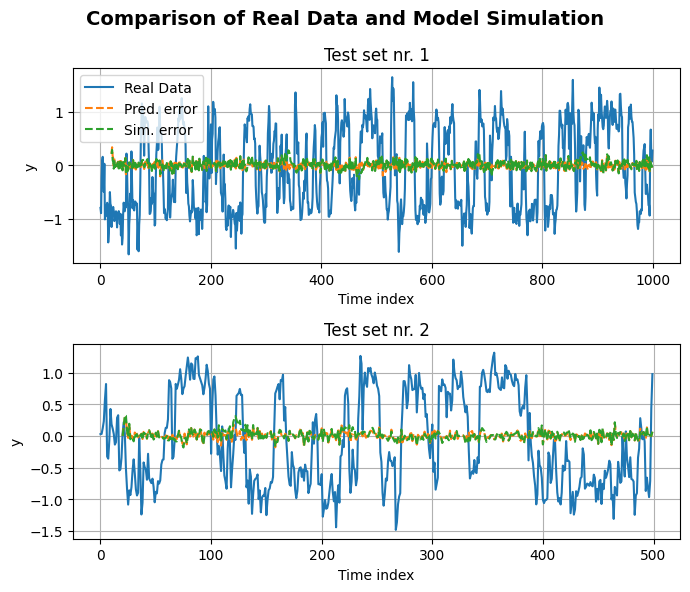

In [8]:
N_exp = len(U_test)
sim_idx = [np.arange(u.shape[0]) for u in U_test]

# Visualize simulation of the model
from matplotlib import pyplot as plt
fig, ax = plt.subplots(N_exp, 1, figsize=(7,6), layout="tight")
fig.suptitle('Comparison of Real Data and Model Simulation', fontsize=14, fontweight='bold')
for i in range(N_exp):
    ax[i].plot(sim_idx[i], Y_test[i], label='Real Data')
    ax[i].plot(sim_idx[i][n_lag:], Y_test_act[i] - Yhat_test_pred[i][:, 0], label='Pred. error', linestyle='--')
    ax[i].plot(sim_idx[i][n_lag:], Y_test[i][n_lag:] - Yhat_test_sim[i][:, 0], label='Sim. error', linestyle='--')
    ax[i].set_xlabel('Time index')
    ax[i].set_ylabel('y')
    ax[i].grid()
    ax[i].set_title(f"Test set nr. {i+1}")
ax[0].legend()
plt.show()